# Laboratorio 1

Alina Carias, Ariela Mishaan, Daniel Machic

## Librerías

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## TASK 2 - PRÁCTICA

### Ejercicio 1: Convolución 2D Genérica

In [5]:
def pad_reflect_manual (img, pad_h, pad_w):

    if pad_h == 0 and pad_w == 0:
        return img.copy()

    H, W = img.shape
    out = np.empty((H + 2*pad_h, W + 2*pad_w), dtype=img.dtype)

    out[pad_h:pad_h+H, pad_w:pad_w+W] = img

    if pad_h > 0:
        out[:pad_h, pad_w:pad_w+W] = img[pad_h:0:-1, :]
        out[pad_h+H:, pad_w:pad_w+W] = img[-2:-2-pad_h:-1, :]

    if pad_w > 0:
        out[:, :pad_w] = out[:, 2*pad_w:pad_w:-1]
        out[:, pad_w+W:] = out[:, pad_w+W-2:pad_w+W-2-pad_w:-1]

    return out

In [16]:
def mi_convolucion(imagen, kernel, padding_type='reflect'):
    if imagen.ndim != 2:
        raise ValueError("Solo en escala de grises (H,W).")

    img = imagen.astype(np.float32, copy=False)
    k = np.array(kernel, dtype=np.float32)

    if k.ndim != 2:
        raise ValueError("El kernel debe ser 2D.")
    if k.shape[0] % 2 == 0 or k.shape[1] % 2 == 0:
        raise ValueError("El kernel debe ser impar (3x3, 5x5...).")

    kh, kw = k.shape
    pad_h, pad_w = kh // 2, kw // 2

    # Convolución real: flip del kernel
    k = np.flipud(np.fliplr(k))

    if padding_type == 'reflect':
        padded = pad_reflect_manual(img, pad_h, pad_w)
    else:
        raise ValueError("Se debe de utilizar reflect como padding_type.")

    H, W = img.shape
    out = np.zeros((H, W), dtype=np.float32)

    for y in range(kh):
        for x in range(kw):
            out += k[y, x] * padded[y:y+H, x:x+W]

    return out

### Ejercicio 2: Generador de Gaussianos

In [ ]:
def generar_gaussiano(tamanio, sigma, mu=0.0):
    tamanio = int(tamanio)
    sigma = float(sigma)
    mu = float(mu)

    if tamanio <= 0 or tamanio % 2 == 0:
        raise ValueError("el tamanio debe ser impar y > 0.")
    if sigma <= 0:
        raise ValueError("sigma debe ser > 0.")

    r = tamanio // 2
    y, x = np.mgrid[-r:r+1, -r:r+1].astype(np.float32)

    g = np.exp(-(((x - mu)**2 + (y - mu)**2) / (2.0 * sigma * sigma)))

    g /= g.sum()

    return g.astype(np.float32)


(Whyamit404, 2025)

### Ejercicio 3: Pipeline de Detección de bordes (Sobel)

In [8]:
def detectar_bordes_sobel(imagen, suavizar=True, tamano_gauss=5, sigma=1.2):
    if imagen.ndim != 2:
        raise ValueError("Solo grayscale (H,W).")

    img = imagen.astype(np.float32, copy=False)
    if suavizar:
        kG = generar_gaussiano(tamano_gauss, sigma)
        img = mi_convolucion(img, kG, padding_type='reflect')

    filtro = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

    gx = mi_convolucion(img, filtro, padding_type='reflect')

    filtro_y = np.flip(filtro.T, axis=0)
    gy = mi_convolucion(img, filtro_y, padding_type='reflect')

    mag = np.sqrt(np.square(gx) + np.square(gy)).astype(np.float32)

    mmax = mag.max()
    if mmax > 0:
        mag_u8 = (mag * (255.0 / mmax)).clip(0, 255).astype(np.uint8)
    else:
        mag_u8 = np.zeros_like(imagen, dtype=np.uint8)

    theta = np.arctan2(gy, gx).astype(np.float32)

    return mag_u8, theta, gx, gy

(Jana, 2019)

## Prueba

In [ ]:
def pipeline_suavizar_y_sobel(imagen, tamanio=5, sigma=1.2):
    # Kernel gaussiano
    k = generar_gaussiano(tamanio, sigma)

    # Suavizado con la convolución
    suav = mi_convolucion(imagen, k, padding_type="reflect")

    # Mantener rango válido para visualizar/guardar
    suav_u8 = np.clip(suav, 0, 255).astype(np.uint8)

    # Sobel
    mag_u8, theta, gx, gy = detectar_bordes_sobel(suav_u8, suavizar=False)

    return suav_u8, mag_u8, theta


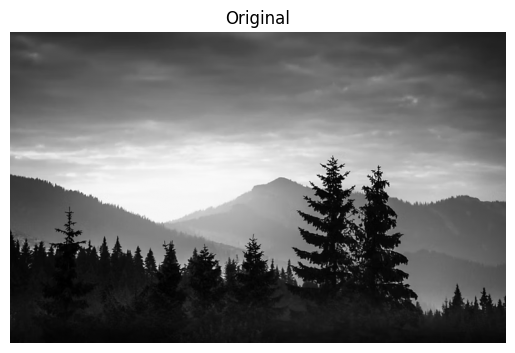

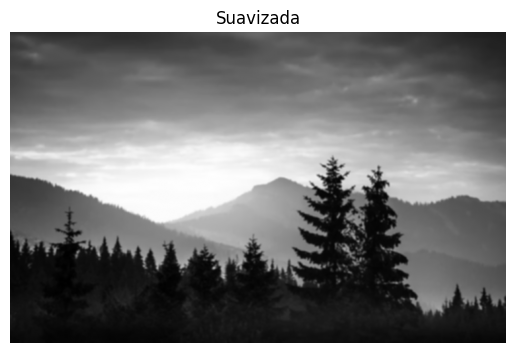

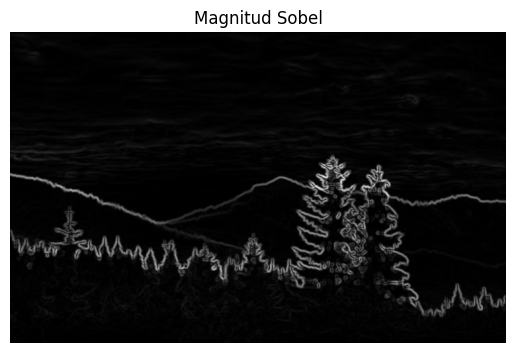

In [ ]:
img = cv2.imread("grises.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se puede leer grises.png. Revisar el nombre y la ruta.")

suav, mag, theta = pipeline_suavizar_y_sobel(img, tamanio=5, sigma=1.2)

plt.figure(); plt.title("Original"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.figure(); plt.title("Suavizada"); plt.imshow(suav, cmap="gray"); plt.axis("off")
plt.figure(); plt.title("Magnitud Sobel"); plt.imshow(mag, cmap="gray"); plt.axis("off")
plt.show()

## Referencias

Jana, A. (2019, 18 mayo). How to implement Sobel edge detection using Python from scratch. A Developer Diary. https://adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/ 

Whyamit404. (2025, 2 febrero). Creating a Gaussian Distribution with NumPy. Medium. https://medium.com/@whyamit404/creating-a-gaussian-distribution-with-numpy-dc810d931ee0 